# Introduction to Data Science 
# Lecture 15: Classification 3
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

In this lecutre, we'll discuss:
* support vector machines (SMV)
* generalizability and cross validation
* comparing classification methods

Recommended Reading: 
* G. James, D. Witten, T. Hastie, and R. Tibshirani, An Introduction to Statistical Learning, Ch. 9 [digitial version available here](http://www-bcf.usc.edu/~gareth/ISL/)


In [1]:
import numpy as np
from sklearn import svm
from sklearn import metrics
from sklearn.datasets import make_moons, load_iris
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

## Support Vector Machines

** Idea: ** Use tools from optimization to find the *best* lines (or hyperplanes or curves) that divide the two datasets. 

### Simplest version first: 2 classes and no "kernel transformation"

Given $n$ samples $(\vec{x}_1,y_1), (\vec{x}_2,y_2),\ldots,(\vec{x}_n,y_n)$, where $x_i$ are attributes or features and $y_i$ are categorical variables that you want to predict. We assume that each $\vec{x}_i$ is a real vector and the $y_i$ are either $1$ or $-1$ indicating the class. 

** Goal: **  Find the "maximum-margin line" or more generally, the "maximum-margin hyperplane" that divides the two classes, which is defined so that the distance between the hyperplane and the nearest point in either group is maximized. 

<img src="https://upload.wikimedia.org/wikipedia/commons/2/2a/Svm_max_sep_hyperplane_with_margin.png" width="400">

$\qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad$ 
source: [wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine)


We can write any line as the set of points $\vec{x}$ satisfying 
$$\vec{w}\cdot\vec{x} = b$$ 
for some (normal) vector $\vec{w}$ and number $b$. The goal is to determine $\vec{w}$ and $b$. Once we have the best values of $\vec{w}$ $b$, our classifier is simply
$$
\vec{x} \mapsto \textrm{sgn}(\vec{w} \cdot \vec{x} - b).
$$

** Hard-margin.** If the data is linearly separable, then we find the separating line (hyperplane) with the *largest margin* ($b/\|w\|$). 

This is given by the solution to the optimization problem 

\begin{align*}
\min_{\vec{w},b}  & \  \|\vec{w}\|  \\ 
\textrm{ subject to } & \  y_i(\vec{w}\cdot\vec{x}_i - b) \ge 1 , \textrm{for } i = 1,\,\ldots,\,n 
\end{align*}


In optimization, this can be written as a *convex optimization problem* and efficiently solved. We'll use scikit-learn. Take Math 5770/6640: Introduction to Optimization to learn more! 

From the picture, the max-margin hyperplane is determined by the $\vec{x}_i$ which are closest to it. These $\vec{x}_i$ are called *support vectors*.


** Soft-margin.** For data that is not linearly separable (e.g., two moons dataset), we introduce *penalty* or *loss* function for violating the constraint that  $y_i(\vec{w}\cdot\vec{x}_i + b) \ge 1$. One of these is the *hinge loss* function, given by 
$$
g(x_i; \vec{w},b) = \max\left(0, 1-y_i(\vec{w}\cdot\vec{x}_i - b)\right). 
$$
We can see that this function is zero if the constraint is satisfied. If the constraint is not satisfied, we pay a penatly, which is proportional to the distance to the separating hyperplane.

We then fix the parameter $C > 0$ and solve the problem 
$$
\min_{\vec{w},b}  \ \frac{1}{n} \sum_{i=1}^n g(x_i; \vec{w},b)  \ + \ C \|\vec{w}\|  . 
$$
The parameter $C$ determines how much we penalize points for being on the wrong side of the line. 

**Q:** How to choose the parameter $C$? Cross Validation! (more on this below)


## SVM and two moons

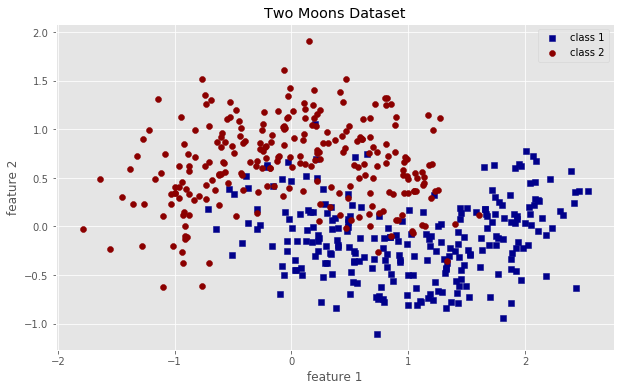

In [2]:
# there are two features contained in X and the labels are contained in y
X,y = make_moons(n_samples=500,random_state=1,noise=0.3)

# Plot the data, color by class
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="DarkBlue", marker="s",label="class 1")
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="DarkRed", marker="o",label="class 2")
plt.legend(scatterpoints=1)
plt.title('Two Moons Dataset')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.show()

In [3]:
model = svm.SVC(kernel='linear', C=10)
model.fit(X, y)    
print(model)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


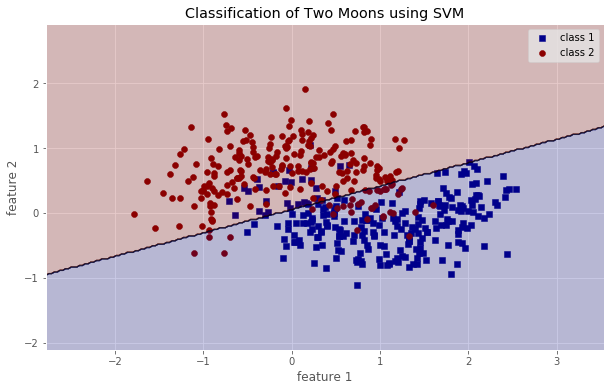

In [4]:
# Plot the data, color by class
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="DarkBlue", marker="s",label="class 1")
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="DarkRed", marker="o",label="class 2")
plt.legend(scatterpoints=1)

# Plot the predictions made by SVM
x_min, x_max = X[:,0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),np.linspace(y_min, y_max, 200))
zz = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, zz, cmap=ListedColormap(['DarkRed', 'DarkBlue']), alpha=.2)
plt.contour(xx, yy, zz, colors="black", alpha=1, linewidths=0.2) 

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Classification of Two Moons using SVM')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.show()

In [5]:
print('Confusion Matrix:')
y_pred = model.predict(X)
print(metrics.confusion_matrix(y_true = y, y_pred = y_pred))

print('Accuracy = ', metrics.accuracy_score(y_true = y, y_pred = y_pred))

Confusion Matrix:
[[213  37]
 [ 33 217]]
Accuracy =  0.86


## Support Vector Machines 

** Basic idea: ** The data may not be linearly separable, but they may be if we apply a nonlinear kernel transformation. 

** Example: ** two "rings" of points

** Hard part: ** Not increasing the computationally complexity of the optimization problem. 


** (Very) rough sketch: **
Replace the linear classifier 
$$
\vec{x} \mapsto \textrm{sgn}(\vec{w} \cdot \vec{x} - b).
$$
with a nonlinear one 
$$
\vec{x} \mapsto \textrm{sgn}( f(x)).
$$

Choices of the nonlinear transformation in scikit-learn are:
- linear: $\langle x, x'\rangle$.
- polynomial: $(\gamma \langle x, x'\rangle + r)^d$. $d$ is specified by keyword degree, $r$ by coef0.
- rbf: $\exp(-\gamma |x-x'|^2)$. $\gamma$ is specified by keyword gamma, must be greater than 0.
- sigmoid:  $\tanh(\gamma \langle x,x'\rangle + r)$, where $r$ is specified by coef0.

The most popular choice is rbf. 

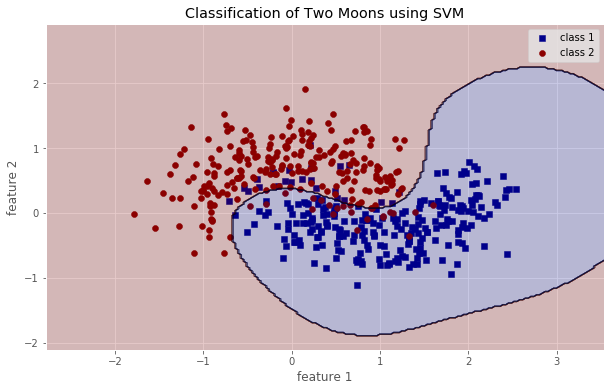

Confusion Matrix:
[[227  23]
 [ 25 225]]
Accuracy =  0.904


In [6]:
model = svm.SVC(kernel='rbf',C=20)
model.fit(X, y)

# Plot the data, color by class
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="DarkBlue", marker="s",label="class 1")
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="DarkRed", marker="o",label="class 2")
plt.legend(scatterpoints=1)

# Plot the predictions made by SVM
x_min, x_max = X[:,0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),np.linspace(y_min, y_max, 200))
zz = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, zz, cmap=ListedColormap(['DarkRed', 'DarkBlue']), alpha=.2)
plt.contour(xx, yy, zz, colors="black", alpha=1, linewidths=0.2) 

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Classification of Two Moons using SVM')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.show()

print('Confusion Matrix:')
y_pred = model.predict(X)
print(metrics.confusion_matrix(y_true = y, y_pred = y_pred))

print('Accuracy = ', metrics.accuracy_score(y_true = y, y_pred = y_pred))

## More than 2 classes?  
There are a few different methods for extending binary classification to more than 2 classes. 
-  **one vs. one:** Consider all pairs of classes (if there are $k$ classes, then there are $\binom k 2$ different pairs of classes. For each pair, we develop a classifier. For a new point, we perform all classifications and then choose the class that was most frequently assigned. (The classifiers all vote on a class.)

- ** all vs. one:**  We compare one of the $k$ classes to the remaining $k-1$ classes. We assign the class to the observation which we are most confident (we have to make this precise).  

### Dataset: The Iris dataset

The dataset contains 4 features (attributes) of 50 samples containing 3 different types of iris plants. The goal is to classify the type of iris plant given the attributes. 

**Features (attributes):**
1. sepal length (cm) 
+ sepal width (cm) 
+ petal length (cm) 
+ petal width (cm) 

**Classes:**
1. Iris Setosa 
+ Iris Versicolour 
+ Iris Virginica

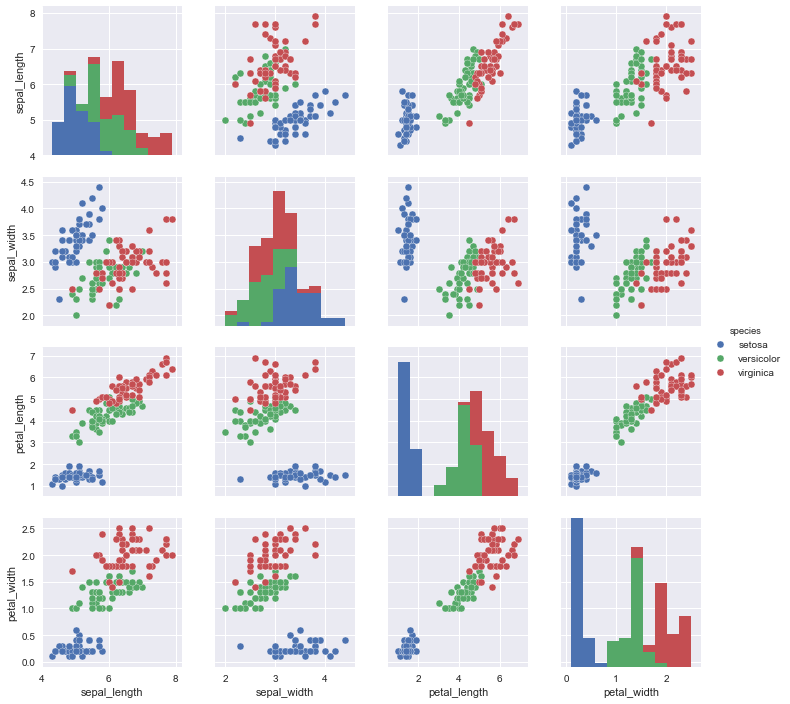

In [7]:
import seaborn as sns
sns.set()

df = sns.load_dataset("iris") # built-in dataset in seaborn 
sns.pairplot(df, hue="species");

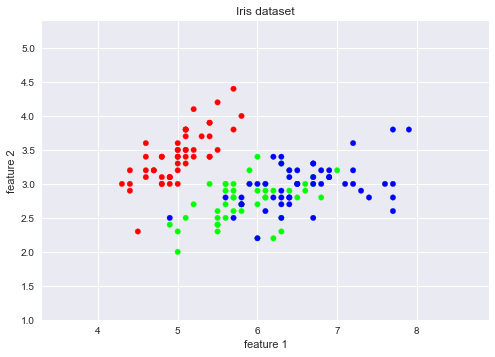

In [8]:
# import data, scikit-learn also has this dataset built-in
iris = load_iris()

# For easy plotting and interpretation, we only use first 2 features here. 
# We're throwing away useful information - don't do this at home! 
X = iris.data[:,:2]
y = iris.target

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# plot data
plt.scatter(X[:, 0], X[:, 1], c=y,  marker="o", cmap=cmap_bold, s=30)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)    
plt.title('Iris dataset')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.show()

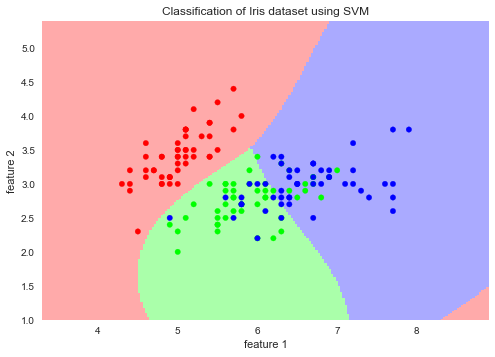

In [9]:
# SVM 
svm_iris = svm.SVC(kernel='rbf',C=3)
svm_iris.fit(X, y)

# plot classification 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),np.linspace(y_min, y_max, 200))
zz = svm_iris.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, zz, cmap=cmap_light)

# plot data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,s=30)

plt.title('Classification of Iris dataset using SVM')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)    
plt.show()

In [10]:
print('Confusion Matrix:')
y_pred = svm_iris.predict(X)
print(metrics.confusion_matrix(y_true = y, y_pred = y_pred))

print('Accuracy = ', metrics.accuracy_score(y_true = y, y_pred = y_pred))

Confusion Matrix:
[[50  0  0]
 [ 0 36 14]
 [ 0 13 37]]
Accuracy =  0.82


## Cross Validation 

** Recall:** Cross validation is a method for assessing how well a model will generalize to an independent data set. 

** Idea:** We split the dataset into a *training set* and a *test set*. We train the model on the training set. We measure the accuracy of the model on the test set. 

There are several different ways to do this. Two popular methods are: 
- **k-fold cross validation** The data is randomly partitioned into k (approximately) equal sized subsamples (folds). For each of the k folds, the method is trained on the other k-1 folds and tested on that fold. The accuracy is computed using each of the k folds as the test set. 
- **leave-one-out cross validation** Same as above with k=n

A variety of function are implemented in scikit-learn for cross validation. 

- The *train_test_split* function randomly splits the data for cross validation
- The *cross_val_score* function splits the data and measures accuracy on test set.  The parameter *cv* is the k in k-fold cross validation. The parameter *scoring* specifies how you want to evaluate the model (we can just use accuracy). 
- The *cross_val_predict* function is similar to *cross_val_score*, but gives you the predictions. 

In [11]:
scores = cross_val_score(estimator = svm_iris, X = iris.data, y = iris.target, cv=5, scoring='accuracy')
print(scores)

predicted = cross_val_predict(estimator = svm_iris, X = iris.data, y = iris.target)
print(predicted)
metrics.accuracy_score(iris.target, predicted) 

[ 0.96666667  1.          0.93333333  0.96666667  1.        ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2
 2 2]


0.97999999999999998

## Incorporating cross-validation to choose SVM parameter, $C$

Recall above that when the data is not linearly separable, introduce a loss function $g$ which penalizes the violation of datapoints lying on the wrong side of the hyperplane and solve the problem 
$$
\min_{\vec{w},b}  \ \frac{1}{n} \sum_{i=1}^n g(x_i; \vec{w},b)  \ + \ C \|\vec{w}\|  . 
$$
Here, the parameter $C>0$ determines how much we penalize points for being on the wrong side of the line. 

Generally, the function *get_params()* an be used to see what parameters are available to change in a model. 

We can use cross-validation to choose the parameter $C$. 

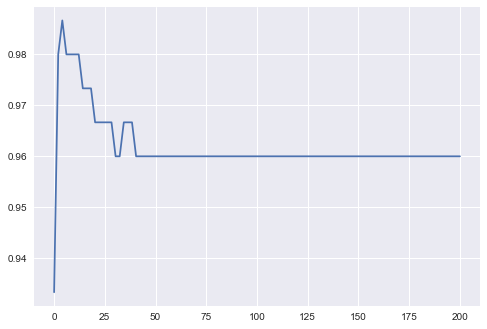

In [12]:
svm_iris.get_params()

Cs = np.linspace(.01,200,100)
Accuracies = np.zeros(Cs.shape[0])
for i,C in enumerate(Cs): 
    svm_iris = svm.SVC(kernel='rbf', C = C)
    scores = cross_val_score(estimator = svm_iris, X = iris.data, y = iris.target, cv=5, scoring='accuracy')    
    Accuracies[i]  = scores.mean()
        
plt.plot(Cs,Accuracies)
plt.show()

Based on the cross validation results, I would choose $C\approx 3$. 